# Taxi Ride Anomalies
This notebook details some basic code to get a simple clustering anomaly detection algorithm up and running. The focus here is not an optimised algorithm, but to create a simple base model from which we can explore the concepts of machine learning engineering in the rest of the book.

# SetUp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(123456789)))

In [2]:
# Define simulate ride data function
def simulate_ride_data():
    # Simulate some ride data ...
    ride_dists = np.concatenate(
        (
            10*np.random.random(size=370),
            30*np.random.random(size=10), #long distances
            10*np.random.random(size=10), #same distance
            10*np.random.random(size=10) #same distance
        )
    )
    ride_speeds = np.concatenate(
        (
            np.random.normal(loc=30, scale=5, size=370),
            np.random.normal(loc=30, scale=5, size=10), # same speed
            np.random.normal(loc=50, scale=10, size=10), # high speed
            np.random.normal(loc=15, scale=4, size=10) #low speed
        )
    )
    ride_times = ride_dists/ride_speeds

    # Assemble into Data Frame
    df = pd.DataFrame(
        {
            'ride_dist': ride_dists, 
            'ride_time': ride_times,  
            'ride_speed': ride_speeds
        }
    )
    ride_ids = datetime.datetime.now().strftime("%Y%m%d")+df.index.astype(str)
    df['ride_id'] = ride_ids

    return df

## The Data
First, we will read in simulated taxi ride data for processing. We assume that the typical Exploratory Data Analysis (EDA) and modelling work have been carried out in detail by the data scientists in your team.

In [3]:
import os
# If data present, read it in
file_path = '../data/taxi-rides.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    df = simulate_ride_data()
    df.to_csv('../data/taxi-rides.csv', index=False)

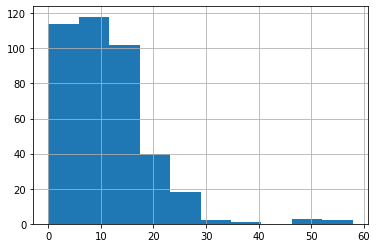

In [4]:
(df['ride_time']*60).hist()

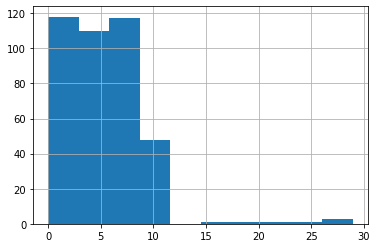

In [5]:
df['ride_dist'].hist()

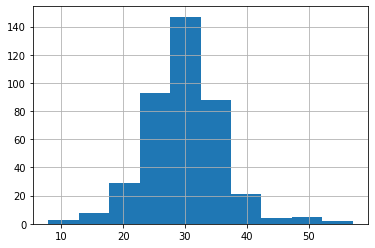

In [6]:
df['ride_speed'].hist()

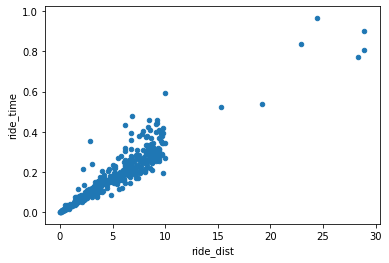

In [7]:
df.plot(x='ride_dist', y='ride_time', kind='scatter')

In [8]:
df.head()

,ride_dist,ride_time,ride_speed,ride_id
0,3.725930,0.116347,32.024258,202102010
1,2.107744,0.075555,27.896846,202102011
2,0.277533,0.008079,34.351335,202102012
3,3.107699,0.110969,28.005100,202102013
4,4.200160,0.186027,22.578203,202102014


# Clustering with DBSCAN

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [10]:
def cluster_and_label(X, create_and_show_plot=True):
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)

    # Find labels from the clustering
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    #print("Adjusted Rand Index: %0.3f"
    #      % metrics.adjusted_rand_score(labels_true, labels))
    #print("Adjusted Mutual Information: %0.3f"
    #      % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    run_metadata = {
        'nClusters': n_clusters_,
        'nNoise': n_noise_,
        'silhouetteCoefficient': metrics.silhouette_score(X, labels),
        'labels': labels,
    }
    if create_and_show_plot == True:
        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = (labels== k)
            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)
            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
    else:
        pass
    return run_metadata

Estimated number of clusters: 1
Estimated number of noise points: 18
Silhouette Coefficient: 0.617


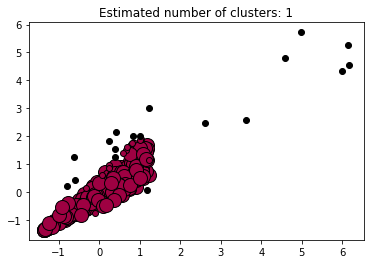

In [11]:
# Create some nice plots
X = df[['ride_dist', 'ride_time']]
results = cluster_and_label(X)
df['label'] = results['labels']

In [12]:
df[df['label']==-1].size

90

In [13]:
df[df['label']==-1].to_json(orient='records')

'[{"ride_dist":6.1512997946,"ride_time":0.4331326178,"ride_speed":14.2018853837,"ride_id":"2021020187","label":-1},{"ride_dist":9.1775726456,"ride_time":0.4572645668,"ride_speed":20.0705965676,"ride_id":"20210201128","label":-1},{"ride_dist":6.7719909282,"ride_time":0.3948133634,"ride_speed":17.1523852959,"ride_id":"20210201260","label":-1},{"ride_dist":6.7877486965,"ride_time":0.3581858365,"ride_speed":18.9503548286,"ride_id":"20210201344","label":-1},{"ride_dist":6.8753997082,"ride_time":0.4795502116,"ride_speed":14.3371841823,"ride_id":"20210201354","label":-1},{"ride_dist":19.1953404413,"ride_time":0.537191431,"ride_speed":35.7327748228,"ride_id":"20210201370","label":-1},{"ride_dist":28.8901328819,"ride_time":0.902440564,"ride_speed":32.0133358734,"ride_id":"20210201371","label":-1},{"ride_dist":15.3300039756,"ride_time":0.5236292094,"ride_speed":29.2764492515,"ride_id":"20210201372","label":-1},{"ride_dist":22.9493131435,"ride_time":0.8390347716,"ride_speed":27.3520406061,"ride_i